### In this script, we will filter households based on certain criteria to ensure only households with high-quality responses/ response rates are kept.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
df_questions = pd.read_csv('selected_survey_questions.csv')
# The file 'selected_survey_questions.csv' includes only the most relevant survey questions. For more information on the filtering process, please refer to the final report.
df_survey_raw = pd.read_csv('responses_to_selected_survey_questions.csv')

# Filter only households in group D, the treatment group
df_survey_d = df_survey_raw[df_survey_raw['Household_id'].str.startswith('D')]
print(f"Number of households in group D who responded to the survey: {len(df_survey_d)}")

Number of households in group D who responded to the survey: 942


### We will remove households based on certain criteria

In [2]:
# Remove specified households from script 1 (insufficient consumption data)
households_to_remove = ['D0041', 'D0093', 'D0125', 'D0134', 'D0212', 'D0241', 'D0332', 'D0381', 'D0417', 'D0477', 'D0586', 'D0643', 'D0668', 'D0723', 'D0734', 'D0862', 'D0873', 'D0967']
df_survey_d = df_survey_d[~df_survey_d['Household_id'].isin(households_to_remove)]
print(f"Number of households removed based on predefined list: {len(households_to_remove)}")
print(f"Number of households remaining after removal: {len(df_survey_d)}")

# Remove households without a single response to Q01-Q17 (attitudes survey)
attitudes_questions = [f'Q{i:02d}' for i in range(1, 18)]
df_survey_d['attitudes_response_count'] = df_survey_d[attitudes_questions].notna().sum(axis=1)
df_survey_attitudes = df_survey_d[df_survey_d['attitudes_response_count'] > 0]
removed_attitudes = len(df_survey_d) - len(df_survey_attitudes)
print(f"2. Number of households removed due to lack of response to attitudes survey: {removed_attitudes}")

# Remove households without a single response to Q18-Q135 (appliances survey)
appliances_questions = [f'Q{i}' for i in range(18, 136)]
df_survey_attitudes['appliances_response_count'] = df_survey_attitudes[appliances_questions].notna().sum(axis=1)
df_survey_filtered = df_survey_attitudes[df_survey_attitudes['appliances_response_count'] > 0]
removed_appliances = len(df_survey_attitudes) - len(df_survey_filtered)
print(f"3. Number of households removed due to lack of response to appliances survey: {removed_appliances}")

# Print how many were removed in each step
print(f"\nTotal households removed: {removed_attitudes + removed_appliances}")
print(f"Final number of households: {len(df_survey_filtered)}")

# Check for duplicate households
duplicate_households = df_survey_filtered[df_survey_filtered.duplicated(subset=['Household_id'], keep=False)]
print(f"\n5. Number of duplicate households: {len(duplicate_households)}")

# Create a dictionary mapping question IDs to full questions
question_dict = dict(zip(df_questions['Question_id'], df_questions['Question']))

Number of households removed based on predefined list: 18
Number of households remaining after removal: 927
2. Number of households removed due to lack of response to attitudes survey: 246
3. Number of households removed due to lack of response to appliances survey: 58

Total households removed: 304
Final number of households: 623

5. Number of duplicate households: 0


C:\Users\RaiN\AppData\Local\Temp\ipykernel_65964\3536988141.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_survey_attitudes['appliances_response_count'] = df_survey_attitudes[appliances_questions].notna().sum(axis=1)


### Next, we will filter households based on response rates.


Top 25 most frequently un-answered questions:
Q34 - Household Member 8 Age | 623
Q26 - Household Member 8 Gender | 623
Q25 - Household Member 7 Gender | 623
Q33 - Household Member 7 Age | 623
Q39 - Accomodation: Mobile | 621
Q32 - Household Member 6 Age | 620
Q121 - TV Type 6 | 620
Q127 - TV Size 6 | 620
Q24 - Household Member 6 Gender | 619
Q126 - TV Size 5 | 615
Q120 - TV Type 5 | 614
Q31 - Household Member 5 Age | 607
Q23 - Household Member 5 Gender | 607
Q119 - TV Type 4 | 585
Q125 - TV Size 4 | 585
Q30 - Household Member 4 Age | 564
Q22 - Household Member 4 Gender | 563
Q17 - Q4 - For each appliance, please circle one code to indicate how you have used timer switches to turn appliances on/off to respond to the High or Low rates Electric water heating (eg, immersion heater) | 548
Q21 - Household Member 3 Gender | 499
Q29 - Household Member 3 Age | 495
Q118 - TV Type 3 | 492
Q124 - TV Size 3 | 491
Q04 - Q2 - Does your household tend to have a fixed routine for WHEN this appliance i

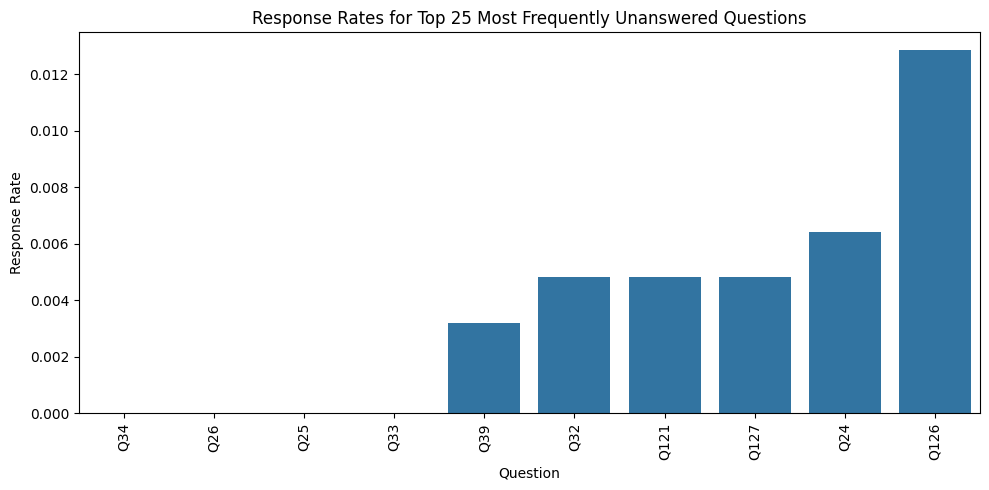

In [3]:
# Find the most frequently un-answered questions
all_response_counts = df_survey_filtered.isna().sum().sort_values(ascending=False)

print("\nTop 25 most frequently un-answered questions:")
for q_id, count in all_response_counts.head(25).items():
    full_question = question_dict.get(q_id, "Question text not found")
    print(f"{q_id} - {full_question} | {count}")

# Visualize response rates for top 25 most frequently unanswered questions
plt.figure(figsize=(10, 5))
sns.barplot(x=all_response_counts.head(10).index, y=1 - (all_response_counts.head(10).values / len(df_survey_filtered)))
plt.title('Response Rates for Top 25 Most Frequently Unanswered Questions')
plt.xlabel('Question')
plt.ylabel('Response Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### From the analysis, it is clear that some questions (such as household member 8's age) should be removed form the top un-answered questions list. Let's create a list of questions to exclude.

In [4]:
# Define the list of questions to exclude
exclude_ranges = [
    (1, 11),    # Appliance-specific questions: Not all households have every appliance
    (12, 17),   # Timer switch usage: Also appliance-specific
    (19, 26),   # Household member gender: Not applicable for all household sizes
    (27, 34),   # Household member age: Not applicable for all household sizes
    (37, 39),   # Accommodation type: Mutually exclusive questions
    (116, 127)  # Specific appliance details (TV): Not all households have these appliances
]
exclude_questions = [f'Q{i:02d}' for r in exclude_ranges for i in range(r[0], r[1]+1)]

# Create a table of excluded questions
excluded_questions_table = pd.DataFrame({
    'Question_ID': exclude_questions,
    'Question': [question_dict.get(q, "Question text not found") for q in exclude_questions]
})

### Let's take a look at what the adjusted response rate (after excluding the questions identified above) looks like

C:\Users\RaiN\AppData\Local\Temp\ipykernel_65964\1734778368.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_survey_filtered.loc[:, 'initial_response_rate'] = df_survey_filtered.notna().sum(axis=1) / total_questions
C:\Users\RaiN\AppData\Local\Temp\ipykernel_65964\1734778368.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_survey_filtered.loc[:, 'adjusted_response_rate'] = df_survey_filtered[included_columns].notna().sum(axis=1) / len(included_columns)


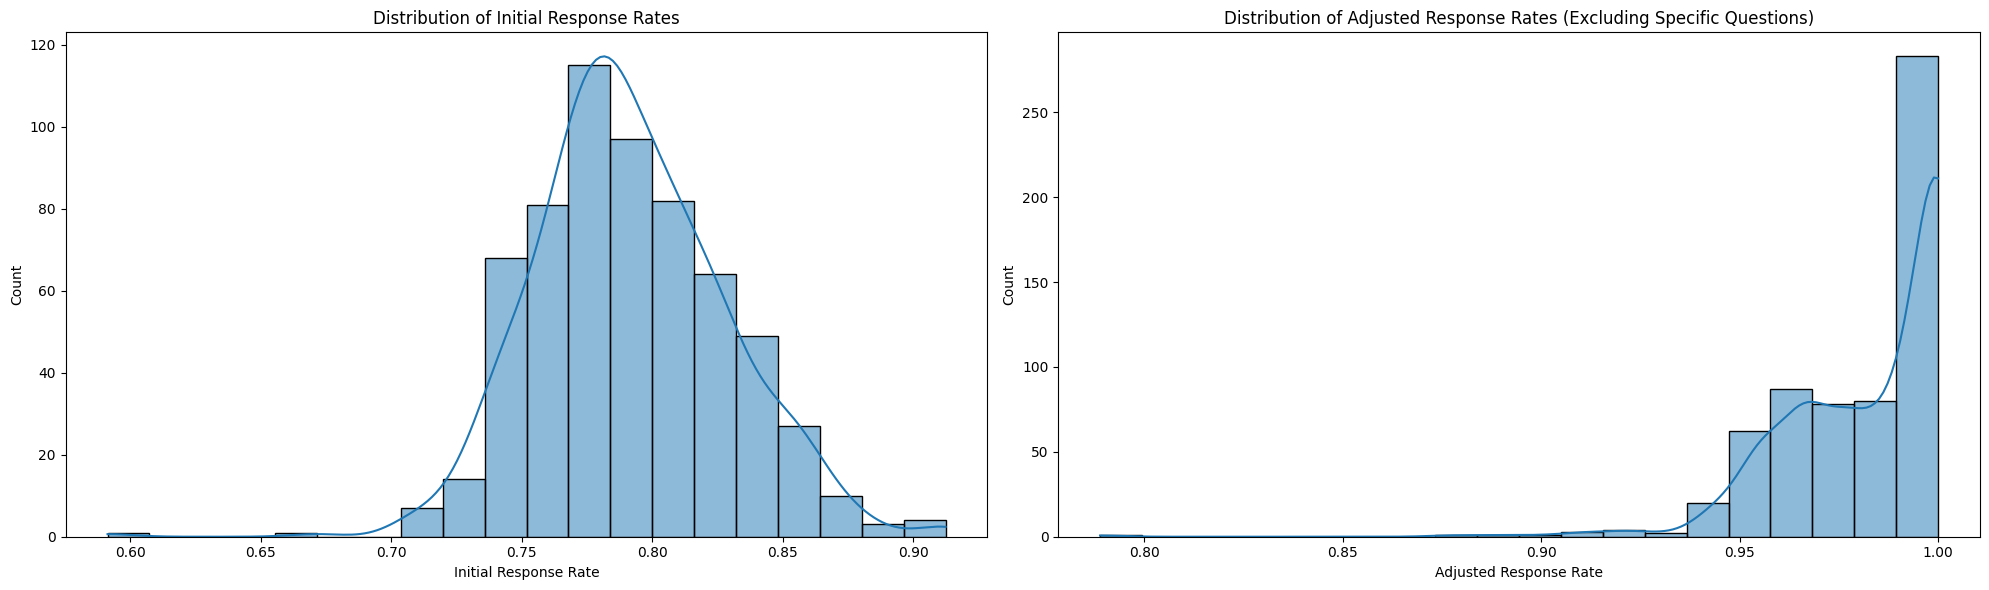


Initial Response Rate Summary Statistics:
count    623.000000
mean       0.791379
std        0.036718
min        0.591241
25%        0.766423
50%        0.788321
75%        0.817518
max        0.912409
Name: initial_response_rate, dtype: float64

Adjusted Response Rate Summary Statistics:
count    623.000000
mean       0.982914
std        0.021444
min        0.788889
25%        0.966667
50%        0.988889
75%        1.000000
max        1.000000
Name: adjusted_response_rate, dtype: float64


In [5]:
# Calculate initial response rate for each household
total_questions = len(df_survey_filtered.columns) - 1  # Subtract 1 to exclude 'Household_id'
df_survey_filtered.loc[:, 'initial_response_rate'] = df_survey_filtered.notna().sum(axis=1) / total_questions

# Calculate adjusted response rate (excluding specific questions identified above)
included_columns = [col for col in df_survey_filtered.columns if col not in exclude_questions and col != 'Household_id']
df_survey_filtered.loc[:, 'adjusted_response_rate'] = df_survey_filtered[included_columns].notna().sum(axis=1) / len(included_columns)

# Visualise initial and adjusted response rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
sns.histplot(df_survey_filtered['initial_response_rate'], bins=20, kde=True, ax=ax1)
ax1.set_title('Distribution of Initial Response Rates')
ax1.set_xlabel('Initial Response Rate')
ax1.set_ylabel('Count')
sns.histplot(df_survey_filtered['adjusted_response_rate'], bins=20, kde=True, ax=ax2)
ax2.set_title('Distribution of Adjusted Response Rates (Excluding Specific Questions)')
ax2.set_xlabel('Adjusted Response Rate')
ax2.set_ylabel('Count')
plt.tight_layout()
plt.show()

# Print summary statistics of response rates
print("\nInitial Response Rate Summary Statistics:")
print(df_survey_filtered['initial_response_rate'].describe())
print("\nAdjusted Response Rate Summary Statistics:")
print(df_survey_filtered['adjusted_response_rate'].describe())

In [6]:
# Calculate number of households missing X% of responses for adjusted response rates
missing_percentages = range(0, 101, 10)
adjusted_missing_counts = [(df_survey_filtered['adjusted_response_rate'] <= (1 - x/100)).sum() for x in missing_percentages]

print("\nNumber of households missing X% or more of responses:")
print("Percentage\tAdjusted Response Rate")
for percent, adjusted_count in zip(missing_percentages, adjusted_missing_counts):
    print(f"Missing {percent}% or more:\t{adjusted_count}")


Number of households missing X% or more of responses:
Percentage	Adjusted Response Rate
Missing 0% or more:	623
Missing 10% or more:	4
Missing 20% or more:	1
Missing 30% or more:	0
Missing 40% or more:	0
Missing 50% or more:	0
Missing 60% or more:	0
Missing 70% or more:	0
Missing 80% or more:	0
Missing 90% or more:	0
Missing 100% or more:	0


### Next, we will eliminate the household(s) with more than 20% non-response rate

In [7]:
# Eliminate households with >20% non-response rate
df_survey_filtered_80 = df_survey_filtered[df_survey_filtered['adjusted_response_rate'] >= 0.8].copy()

print(f"\nNumber of households removed due to >20% non-response rate: {len(df_survey_filtered) - len(df_survey_filtered_80)}")
print(f"Number of households after removing those with >20% non-response rate: {len(df_survey_filtered_80)}")


Number of households removed due to >20% non-response rate: 1
Number of households after removing those with >20% non-response rate: 622


### We will also remove households for which all three pieces of demographic information are inconsistent
#### for example, a household has a size of 3, but lists 2 genders, and has the age range for only 1 member

In [8]:
# Function to check if all demographic information is missing or inconsistent
def demo_missing_or_inconsistent(row):
    household_size_missing = pd.isna(row['Q18'])
    all_gender_missing = all(pd.isna(row[f'Q{i}']) for i in range(19, 27))
    all_age_missing = all(pd.isna(row[f'Q{i}']) for i in range(27, 35))
    
    # Check if all are missing
    all_missing = household_size_missing and all_gender_missing and all_age_missing
    
    # Check if all three disagree
    size = row['Q18'] if pd.notna(row['Q18']) else 0
    gender_count = sum(pd.notna(row[f'Q{i}']) for i in range(19, 27))
    age_count = sum(pd.notna(row[f'Q{i}']) for i in range(27, 35))
    all_disagree = (size != gender_count) and (size != age_count) and (gender_count != age_count)
    
    return all_missing or all_disagree

# Identify households with all demographic information missing or inconsistent
df_survey_filtered_80.loc[:, 'demo_missing_or_inconsistent'] = df_survey_filtered_80.apply(demo_missing_or_inconsistent, axis=1)

# Remove these households
df_survey_final = df_survey_filtered_80[~df_survey_filtered_80['demo_missing_or_inconsistent']].copy()

households_removed_demo = len(df_survey_filtered_80) - len(df_survey_final)
print(f"\nNumber of households removed due to missing all demographic information or inconsistencies: {households_removed_demo}")
print(f"\nTotal number of households remaining in the final dataset: {len(df_survey_final)}")


Number of households removed due to missing all demographic information or inconsistencies: 14

Total number of households remaining in the final dataset: 608


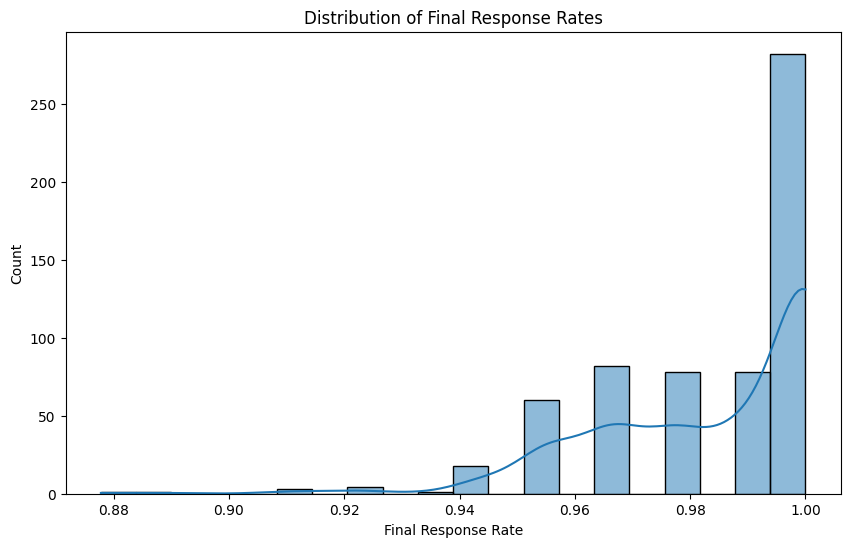


Number of households missing X% or more of responses:
Percentage	Final
Missing 5% or more:	28
Missing 6% or more:	10
Missing 7% or more:	9
Missing 8% or more:	5
Missing 9% or more:	2
Missing 10% or more:	2


In [9]:
# Visualise final response rates
plt.figure(figsize=(10, 6))
sns.histplot(df_survey_final['adjusted_response_rate'], bins=20, kde=True)
plt.title('Distribution of Final Response Rates')
plt.xlabel('Final Response Rate')
plt.ylabel('Count')
plt.show()

# Calculate number of households missing X% of responses for final rates
missing_percentages = range(5, 11)
final_missing_counts = [(df_survey_final['adjusted_response_rate'] <= (1 - x/100)).sum() for x in missing_percentages]

print("\nNumber of households missing X% or more of responses:")
print("Percentage\tFinal")
for percent, final_count in zip(missing_percentages, final_missing_counts):
    print(f"Missing {percent}% or more:\t{final_count}")

### We can also explore which questions are remain unanswered the most frequently

In [10]:
# Find all un-answered questions in the final dataset
response_counts = df_survey_final[included_columns].isna().sum().sort_values(ascending=False)
response_counts = response_counts[response_counts > 0]  # Exclude questions with zero non-responses

print("\nAll questions with non-zero non-responses, sorted by frequency:")
for q_id, count in response_counts.items():
    full_question = question_dict.get(q_id, "Question text not found")
    print(f"{q_id} - {full_question} | {count}")


All questions with non-zero non-responses, sorted by frequency:
Q45 - Insulation: Floor insulation | 250
Q44 - Insulation: Wall insulation | 202
Q46 - Insulation: Hot water tank insulation/lagging | 141
Q43 - Insulation: Roof or loft insulation | 106
Q48 - Central heating - control | 50
Q42 - Insulation: Double glazing | 34
Q18 - Household Size | 18
Q36 - Work from home | 12
Q129 - Frequency press buttons on smart meter - You | 10
Q134 - How helpful is smart meter in understanding consumption | 9
Q35 - Home Ownership Status | 8
Q131 - Interest in micro-generation | 8
Q135 - How helpful is smart meter in managingconsumption | 8
Q128 - Frequency look at smart meter - You | 6
Q47 - Central heating | 6
Q130 - Interest in getting electricity from a renewable energy source | 5
Q132 - Concern about climate change | 4
Q133 - Feel about current  lifestyle and the environment | 3
Q49 - Heating water | 3
Q41 - Bedrooms | 3
Q40 - Rooms in home | 3


In [11]:
# Drop temporary columns
df_survey_final_export = df_survey_final.drop(columns=['initial_response_rate', 'adjusted_response_rate', 'attitudes_response_count', 'appliances_response_count', 'demo_missing_or_inconsistent'])

# Export the final cleaned dataset
df_survey_final_export.to_csv('2) responses_to_selected_survey_questions_filtered.csv', index=False)
print("\nFinal cleaned survey dataset has been exported to ''2) responses_to_selected_survey_questions_filtered.csv'")


Final cleaned survey dataset has been exported to ''2) responses_to_selected_survey_questions_filtered.csv'
